In [1]:
from data import MultiMolGraphDataset
from torch_geometric.loader import DataLoader
import torch
import torchmetrics
from torchmetrics import MeanAbsoluteError

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
sdf_path = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data'
target_data = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data.csv'

In [3]:
# Read in target_data with pandas and then select 'psi_1_dihedral' column and convert the dihedral angles to sin and cos 
import pandas as pd
import numpy as np
# 1 & 2. Load your data
target_df = pd.read_csv(target_data)

# Drop -10 rows in the dihedral angle column
target_df = target_df[target_df['psi_1_dihedral'] != -10]

# 3. Extract the dihedral angles
angles = target_df['psi_1_dihedral']

# 3.1 Remove any -10 rows in the dihedral angle column
angles = angles[angles != -10]
# 3.2 Remove any NaN values
angles = angles.dropna()

# 4. If angles are in degrees, convert to radians
angles_rad = np.deg2rad(angles)

# 5. Compute sin & cos and assign
target_df['psi_1_dihedral_sin'] = np.sin(angles_rad)
target_df['psi_1_dihedral_cos'] = np.cos(angles_rad)

# Optional: inspect
print(target_df[['psi_1_dihedral', 'psi_1_dihedral_sin', 'psi_1_dihedral_cos']].head())



# 6. Save the modified DataFrame back to CSV
target_data = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data_sin_cos.csv'
target_df.to_csv(target_data, index=False)

   psi_1_dihedral  psi_1_dihedral_sin  psi_1_dihedral_cos
0      313.550300           -0.724770            0.688991
2      292.580884           -0.923338            0.383987
3      233.012473           -0.798766           -0.601641
4       34.468778            0.565957            0.824435
5      202.755671           -0.386802           -0.922163


In [4]:
mol_dataset = MultiMolGraphDataset(
    root='.',
    sdf_folder=sdf_path,
    input_type=['r1h', 'r2h'],
    target_csv=target_data,
    target_columns=['psi_1_dihedral_sin', 'psi_1_dihedral_cos'],
    keep_hs=True,
    sanitize=False,
    force_reload=True
)

Processing...


No target for 'rmg_rxn_1129' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1129.sdf
No target for 'rmg_rxn_1137' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1137.sdf
No target for 'rmg_rxn_1141' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1141.sdf
No target for 'rmg_rxn_1142' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1142.sdf
No target for 'rmg_rxn_1146' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1146.sdf
No target for 'rmg_rxn_1147' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1147.sdf
No target for 'rmg_rxn_1152' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1152.sdf
No target for 'rmg_rxn_1153' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1153.sdf
No target for 'rmg_rxn_1

Done!


In [5]:
mol_dataset[4]

PairData(y=[1, 2], id='kfir_rxn_11797', x_s=[8, 133], edge_index_s=[2, 16], edge_attr_s=[16, 27], x_t=[7, 133], edge_index_t=[2, 12], edge_attr_t=[12, 27], num_nodes_s=[1], num_nodes_t=[1], num_nodes=15)

In [6]:
len(mol_dataset[0].edge_attr_s[0])

27

In [7]:
# Split the dataset into train and test sets and val sets [0.8, 0.1, 0.1]
train_size = int(0.8 * len(mol_dataset))
test_size = int(0.1 * len(mol_dataset))
val_size = len(mol_dataset) - train_size - test_size

import torch
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(
    mol_dataset,
    [train_size, test_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(
    train_dataset,
    batch_size = 16,
    shuffle    = True,
    follow_batch = ['x_s', 'x_t']    # tells PyG to create x_s_batch, x_t_batch
)
test_loader = DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle    = False,
    follow_batch = ['x_s', 'x_t']    # tells PyG to create x_s_batch, x_t_batch
)
val_loader = DataLoader(
    val_dataset,
    batch_size = 32,
    shuffle    = False,
    follow_batch = ['x_s', 'x_t']    # tells PyG to create x_s_batch, x_t_batch
)

In [8]:
for batch in train_loader:
    print("Edge index shape:", batch.edge_index_s.shape)
    print("Edge attr shape:", batch.edge_attr_s.shape)

    print("Example edge feature vector:", batch.edge_attr_s[0])
    break

Edge index shape: torch.Size([2, 272])
Edge attr shape: torch.Size([272, 27])
Example edge feature vector: tensor([ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  7.2456e-14,
         8.1888e-07,  1.9299e-02,  9.4845e-01,  9.7200e-02,  2.0773e-05,
         9.2572e-12,  8.6029e-21,  1.6671e-32,  0.0000e+00,  9.9152e-01,
        -1.2996e-01,  1.0000e+00], dtype=torch.float64)


In [9]:
angle_masks = batch.edge_attr_s[:, -1]  # the last column
print("Angle mask values:", angle_masks.unique())


Angle mask values: tensor([-10.,   1.], dtype=torch.float64)


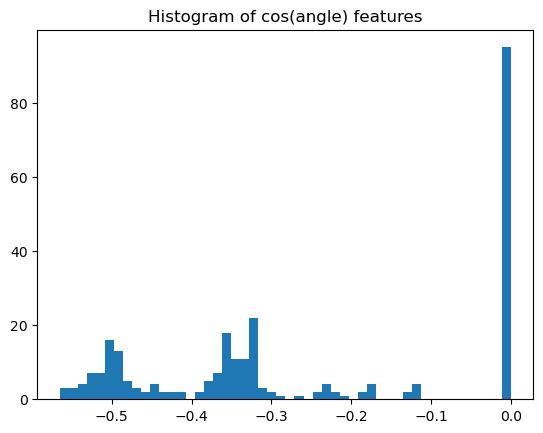

In [10]:
import matplotlib.pyplot as plt

plt.hist(batch.edge_attr_s[:, -2].numpy(), bins=50)  # cos(angle)
plt.title("Histogram of cos(angle) features")
plt.show()


In [11]:
# after you have made train_loader / val_loader
from collections import Counter
all_train_ids = []
all_val_ids   = []

for pair in train_loader.dataset:          # ← adjust .dataset attr if needed
    all_train_ids.append(pair.id)          # whatever unique key you use
for pair in val_loader.dataset:
    all_val_ids.append(pair.id)

leak = set(all_train_ids) & set(all_val_ids)
print(f"duplicated IDs between train/val: {len(leak)}")
assert len(leak) == 0, "⚠️ data leakage!"

duplicated IDs between train/val: 0


In [12]:
# Check that sin^2 + cos^2 are normalized
import numpy as np
tem_targets = []
for data in train_loader:
    tem_targets.append(data.y)
tem_targets = torch.cat(tem_targets, dim=0)
norms = torch.norm(tem_targets, dim=1)

# Check that sin^2 + cos^2 are normalized
assert torch.allclose(norms, torch.ones_like(norms), atol=1e-4), "Targets not normalized!"


In [13]:
from siamesepairwise import SiamesePairwise
from gine import GINEEncoder

In [22]:
gnn = GINEEncoder(
    node_in=133,
    edge_in=27,
    hidden=256,
    depth=5,
    edge_proj=True,
    dropout=0.3,
    use_batchnorm=True,
    pooling='global_attention'
)

/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


In [23]:
model = SiamesePairwise(
    encoder=gnn,
    n_targets=2,
    fusion='symm',
    head_hidden_dims=[512, 256],
    dropout=0.3,
)

In [24]:
model

SiamesePairwise(
  (encoder): GINEEncoder(
    (edge_proj): Linear(in_features=27, out_features=256, bias=False)
    (input_proj): Linear(in_features=133, out_features=256, bias=True)
    (convs): ModuleList(
      (0-4): 5 x GINEConv(nn=Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      ))
    )
    (bns): ModuleList(
      (0-4): 5 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (dropout_gnn): Dropout(p=0.3, inplace=False)
    (pool): GlobalAttention(gate_nn=Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=1, bias=True)
    ), nn=None)
    (readout): Linear(in_features=256, out_features=256, bias=True)
    (head): Sequential(
      (0): Linear(in_features=256, out_f

In [25]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

class CosineRestartsDecay(CosineAnnealingWarmRestarts):
    """
    CosineAnnealingWarmRestarts + multiplicative decay at each restart,
    without the deprecated `verbose` argument.
    """
    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        T_0: int,
        decay: float = 0.3,
        T_mult: int = 1,
        eta_min: float = 0,
        last_epoch: int = -1,
    ):
        # store decay before init
        self.decay = decay

        # initialize parent WITHOUT verbose
        super().__init__(
            optimizer,
            T_0       = T_0,
            T_mult    = T_mult,
            eta_min   = eta_min,
            last_epoch= last_epoch,
        )

    def step(self, epoch=None):
        super().step(epoch)

        # do NOT decay at epoch 0
        if self.T_cur == 0 and self.last_epoch > 0:
            self.base_lrs = [lr * self.decay for lr in self.base_lrs]
            for g, new_base in zip(self.optimizer.param_groups, self.base_lrs):
                g['initial_lr'] = new_base


In [26]:
from torchmetrics import MeanAbsoluteError
from loss_utils import CircularMSELoss, cosine_angle_loss, weighted_cosine_loss, von_mises_nll_per_sample, radial_penalty, von_mises_nll


#loss_fn = MeanAbsoluteError().to(device='cuda')
loss_fn = von_mises_nll_per_sample
# optim  = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
enc_lr  =  3e-4        # head LR stays as before
head_lr =  1e-4        # 3× for the MLP

optim = torch.optim.AdamW(
    [{'params': gnn.parameters(),               'lr': enc_lr},
     {'params': model.head.parameters(),        'lr': head_lr}],
     weight_decay = 5e-5)

sched = CosineRestartsDecay(
            optim,
            T_0     = 20,
            T_mult  = 2,
            eta_min = 1e-4,
            decay   = 0.6)   # ≈ γ
model = model.to(device)

In [27]:
# ---------------------------------------------------
# helpers -------------------------------------------
# ---------------------------------------------------
def unit(v, eps: float = 1e-8):
    return v / v.norm(dim=-1, keepdim=True).clamp(min=eps)

def dot_unit(a, b, eps: float = 1e-8):
    """safe dot(a/‖a‖, b/‖b‖)  in  [-1, +1]"""
    return (unit(a, eps) * unit(b, eps)).sum(dim=-1).clamp(-1.+1e-7, 1.-1e-7)

def cos_loss(pred, tgt):
    # (1 – cosθ)  –– identical to your current cosine-angle loss
    return 1. - dot_unit(pred, tgt)

def l2_loss(pred, tgt):
    # ‖ûpred – ûtgt‖²  –– smoother around the wrap point
    return (unit(pred) - unit(tgt)).pow(2).sum(dim=-1)


In [28]:
angle_abs_delta = []

# ----------------------------------------
# 0.  PRE-COMPUTE the per–bin weights once
# ----------------------------------------
#  – do this **before** the training loop –
bin_edges = torch.arange(0, 361, 5, device=device)         # 5° bins
hist      = torch.zeros(len(bin_edges)-1, device=device)    # counts

# pass once over the TRAIN set to fill the histogram
for pair in train_loader:
    ang = torch.atan2(pair.y[:,1], pair.y[:,0])
    ang = torch.rad2deg(ang) % 360
    counts_cpu = torch.histc(
        ang,
        bins = len(bin_edges)-1,
        min  =   0,
        max  = 360
    )
    hist += counts_cpu.to(device)

from scipy.ndimage import gaussian_filter1d
smooth_hist = torch.tensor(
        gaussian_filter1d(hist.cpu().float().numpy(), sigma=1), device=device)
inv_freq = 1. / (smooth_hist + 1e-6)
weights  = (inv_freq / inv_freq.mean()).clamp(max=3.0, min=0.3)

# inv_freq  = 1. / (hist + 1e-6)
# weights   = inv_freq / inv_freq.mean()      # normalised → mean ≈ 1
# print(f"Sample weights: {weights}")
# weights   = weights.clamp(max=3.0)          # ← NEW: at most ×3
print(f"Sample weights clamped: {weights}")
# ----------------------------------------
num_epochs   = 200
best_val_loss = float('inf')
eps = 1e-8    
warmup_epochs = 10
base_enc_lr = 3e-5  # Start 10x lower
kappa = 6.0

for epoch in range(1, num_epochs + 1):
    model.train()
    for pair in train_loader:
        pair = pair.to(device)
        pred = model(pair)

        # ---------- PER-SAMPLE cosine-angle loss ----------
        # (exactly the same algebra as your helper but WITHOUT the final .mean())
        p_hat = pred / pred.norm(dim=-1, keepdim=True).clamp(min=eps)
        t_hat = pair.y / pair.y.norm(dim=-1, keepdim=True).clamp(min=eps)
        dot   = (p_hat * t_hat).sum(dim=-1).clamp(-1.0, 1.0)   # shape [batch]
        per_sample_loss = von_mises_nll_per_sample(pred, pair.y, kappa=kappa)                           # shape [batch]

        # ---------- look-up sample weights ----------
        ang      = torch.atan2(pair.y[:, 1], pair.y[:, 0])     # rad
        ang_deg  = torch.rad2deg(ang) % 360
        bin_idx  = torch.bucketize(ang_deg, bin_edges) - 1
        sample_w = weights[bin_idx]                            # shape [batch]

        # ---------- weighted batch loss ----------
        loss = (sample_w * per_sample_loss).mean() + 0.1 * radial_penalty(pred, pair.y).mean()  # ← NEW: radial penalty

        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(
                                                    model.parameters(), 
                                                    max_norm=1.0,
                                                    error_if_nonfinite=True
                                                )
        # print(f"Train Loss: total={loss.item():.4f} | angle={((sample_w * per_sample_loss).mean()).item():.4f} | radial={radial_penalty(pred, pair.y).mean().item():.4f}")
        optim.step(); optim.zero_grad()

    # Step the scheduler
    sched.step(epoch=epoch)

    # ---------------- VALIDATE -------------
    model.eval()
    with torch.no_grad():
        # ---------------- VALIDATE -------------
        val_loss = 0.0
        n = 0
        for pair in val_loader:
            pair = pair.to(device)
            pred = model(pair)
            batch_losses = loss_fn(pred, pair.y, kappa=kappa)
            val_loss += batch_losses.sum().item()
            n += pred.size(0)
        val_loss = val_loss / n

        # ----------- TRAIN LOSS (EVAL MODE) -------------
        train_loss = 0.0
        n = 0
        for pair in train_loader:
            pair = pair.to(device)
            pred = model(pair)
            batch_losses = loss_fn(pred, pair.y, kappa=kappa)
            train_loss += batch_losses.sum().item()
            n += pred.size(0)
        train_loss = train_loss / n

        print(f"Epoch {epoch:3d} | train {train_loss:.4f} | "
            f"val {val_loss:.4f} | enc-lr {optim.param_groups[0]['lr']:.2e} "
            f"| head-lr {optim.param_groups[1]['lr']:.2e}")

        # ------------- ANGULAR ERROR -------------
        ang_err = 0.0
        n = 0
        for pair in val_loader:
            pair = pair.to(device)
            pred = model(pair)
            dot = dot_unit(pred, pair.y).clamp(-1 + 1e-6, 1 - 1e-6)
            theta = torch.rad2deg(torch.acos(dot))
            ang_err += theta.sum().item()
            n += pred.size(0)
        avg_ang_err = ang_err / n
        print(f'⟨|Δθ|⟩ = {avg_ang_err:6.2f} °')
        angle_abs_delta.append(avg_ang_err)


        # ------------- CHECKPOINT --------------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best.pt')


Sample weights clamped: tensor([0.8005, 0.8151, 0.7740, 0.7230, 0.6581, 0.6150, 0.6884, 0.8214, 0.9116,
        0.8117, 0.6570, 0.6047, 0.6362, 0.6492, 0.6109, 0.5291, 0.3531, 0.3000,
        0.3000, 0.3367, 0.4869, 0.5479, 0.5575, 0.5673, 0.5778, 0.6734, 0.7137,
        0.5884, 0.5401, 0.5965, 0.6611, 0.7205, 0.8136, 0.9017, 0.9446, 0.9558,
        0.9221, 1.0244, 1.2850, 1.4179, 1.3481, 1.2229, 1.1033, 1.1514, 1.2651,
        1.3847, 1.6713, 1.8822, 1.7149, 1.4286, 1.2021, 1.1324, 0.9833, 0.7658,
        0.7546, 1.0549, 1.2761, 1.2101, 1.4299, 1.7201, 1.8578, 1.9960, 2.0891,
        1.8174, 1.5301, 1.3097, 1.1665, 1.3605, 1.5704, 1.3479, 1.1680, 1.1073],
       device='cuda:0')
Epoch   1 | train 4.5806 | val 5.0571 | enc-lr 2.99e-04 | head-lr 1.00e-04
⟨|Δθ|⟩ =  78.08 °
Epoch   2 | train 4.6948 | val 5.2573 | enc-lr 2.95e-04 | head-lr 1.00e-04
⟨|Δθ|⟩ =  80.53 °
Epoch   3 | train 4.3105 | val 4.9558 | enc-lr 2.89e-04 | head-lr 1.00e-04
⟨|Δθ|⟩ =  76.76 °
Epoch   4 | train 4.2764 | val 4

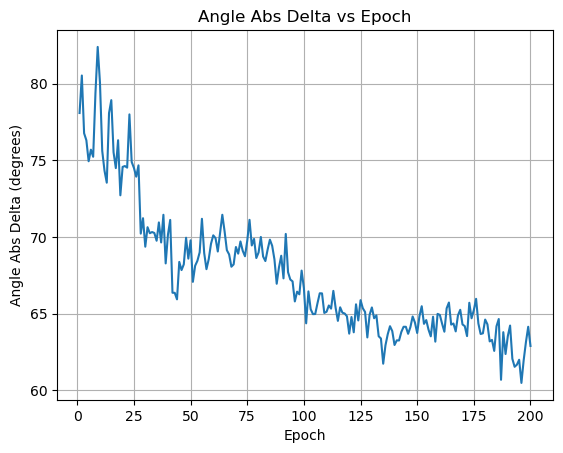

In [ ]:
# Plot angle_abs_delta vs epoch
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(1, num_epochs + 1), angle_abs_delta)
plt.xlabel('Epoch')
plt.ylabel('Angle Abs Delta (degrees)')
plt.title('Angle Abs Delta vs Epoch')
plt.grid()
plt.show()

# GLobalAttention

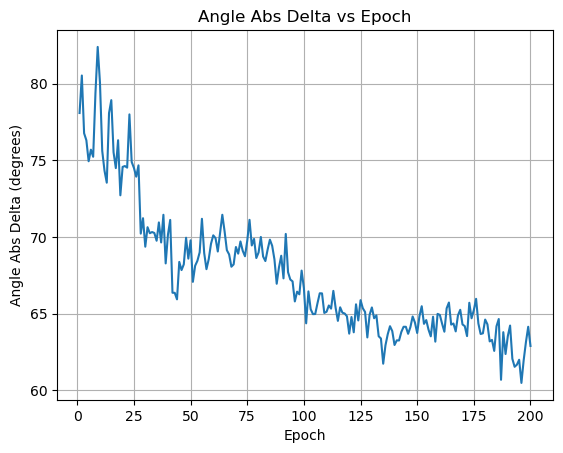

In [31]:
# Plot angle_abs_delta vs epoch
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(1, num_epochs + 1), angle_abs_delta)
plt.xlabel('Epoch')
plt.ylabel('Angle Abs Delta (degrees)')
plt.title('Angle Abs Delta vs Epoch')
plt.grid()
plt.show()

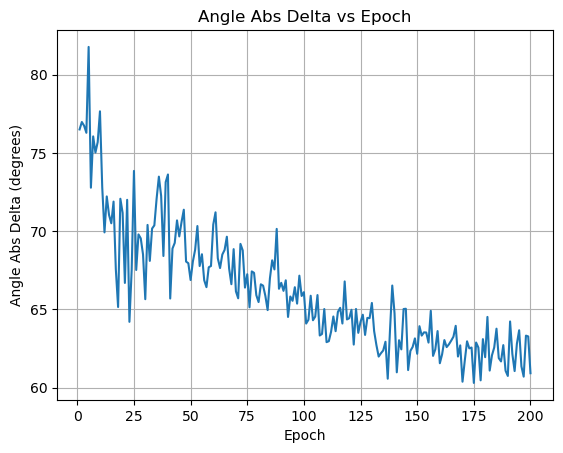

In [ ]:
# Plot angle_abs_delta vs epoch
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(1, num_epochs + 1), angle_abs_delta)
plt.xlabel('Epoch')
plt.ylabel('Angle Abs Delta (degrees)')
plt.title('Angle Abs Delta vs Epoch')
plt.grid()
plt.show()

# Mean Pooling

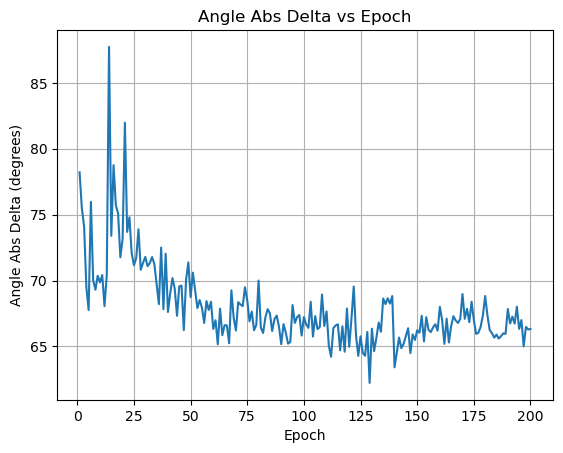

In [17]:
# Plot angle_abs_delta vs epoch
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(1, num_epochs + 1), angle_abs_delta)
plt.xlabel('Epoch')
plt.ylabel('Angle Abs Delta (degrees)')
plt.title('Angle Abs Delta vs Epoch')
plt.grid()
plt.show()

In [18]:
# ---------- from the TRAIN loader ----------
train_y = torch.cat([pair.y for pair in train_loader], dim=0)
train_ang = torch.rad2deg(torch.atan2(train_y[:,1], train_y[:,0])) % 360
bin_edges   = torch.arange(0, 361, 10, device=train_y.device)
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

# mean unit vector of each bin
bin_mean = torch.zeros((len(bin_centres), 2), device=train_y.device)
for b in range(len(bin_centres)):
    mask = (train_ang >= bin_edges[b]) & (train_ang < bin_edges[b+1])
    if mask.any():
        v = train_y[mask]
        bin_mean[b] = v.mean(0) / (v.norm(dim=1, keepdim=True)+1e-8).mean()
    else:                       # empty bin → fallback = bin-centre direction
        phi = torch.deg2rad(bin_centres[b])
        bin_mean[b] = torch.tensor([torch.cos(phi), torch.sin(phi)],
                                   device=train_y.device)
bin_mean = bin_mean / bin_mean.norm(dim=1, keepdim=True)        # unit vectors
val_y   = torch.cat([pair.y for pair in val_loader], dim=0)
val_ang = torch.rad2deg(torch.atan2(val_y[:,1], val_y[:,0])) % 360
bin_idx = torch.bucketize(val_ang, bin_edges) - 1
pseudo_pred = bin_mean[bin_idx]

eps   = 1e-8
dot   = (pseudo_pred * val_y).sum(1).clamp(-1+eps, 1-eps)
theta = torch.rad2deg(torch.acos(dot))
print(f"prototype-baseline ≈ {theta.mean():5.2f} °")


prototype-baseline ≈  2.76 °


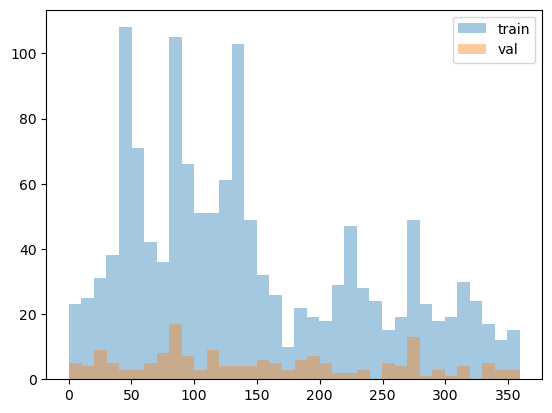

In [19]:
import matplotlib.pyplot as plt
for name, loader in [('train', train_loader), ('val', val_loader)]:
    a = torch.rad2deg(torch.atan2(
        torch.cat([p.y for p in loader],0)[:,1],
        torch.cat([p.y for p in loader],0)[:,0])) % 360
    plt.hist(a.cpu(), bins=36, alpha=.4, label=name)
plt.legend(); plt.show()


In [20]:
from torch.utils.data import random_split
from copy import deepcopy

# 80/20 split like before (adjust to your ratio)
N = len(mol_dataset)
val_len = int(0.2 * N)
train_len = N - val_len

# ❶ make a *different* random split
new_train, new_val = random_split(mol_dataset,
                                  lengths=[train_len, val_len],
                                  generator=torch.Generator().manual_seed(42))

new_val_loader = DataLoader(
    new_val,
    batch_size = 32,
    shuffle    = False,
    follow_batch = ['x_s', 'x_t']    # tells PyG to create x_s_batch, x_t_batch
)

# ❷ evaluate current model on that *shuffled* val-set
model.eval(); new_loss = 0.; n = 0
with torch.no_grad():
    for batch in new_val_loader:
        batch = batch.to(device)
        pred  = model(batch)
        new_loss += loss_fn(pred, batch.y.to(device)) * pred.size(0)
        n += pred.size(0)

new_loss = (new_loss / n).item()
print(f"val-loss on shuffled split: {new_loss:.4f}")


RuntimeError: The size of tensor a (32) must match the size of tensor b (19) at non-singleton dimension 0

In [ ]:
import torch, math

model.eval()
angles_deg = []

with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)

        # -- forward
        pred = model(batch)          # shape [B, 3] or [B, 2] depending on your encoding
        tgt  = batch.y

        # (a)  make sure both vectors are unit-norm
        pred = torch.nn.functional.normalize(pred, dim=-1)
        tgt  = torch.nn.functional.normalize(tgt,  dim=-1)

        # (b)  cosine similarity  →  angle
        cos_sim = (pred * tgt).sum(-1).clamp(-1.+1e-7, 1.-1e-7)
        angle   = torch.rad2deg(torch.acos(cos_sim))   # in degrees
        angles_deg.append(angle.cpu())

mean_angle = torch.cat(angles_deg).mean().item()
print(f"⟨|Δθ|⟩ on validation :  {mean_angle:5.2f} °")


⟨|Δθ|⟩ on validation :  66.42 °


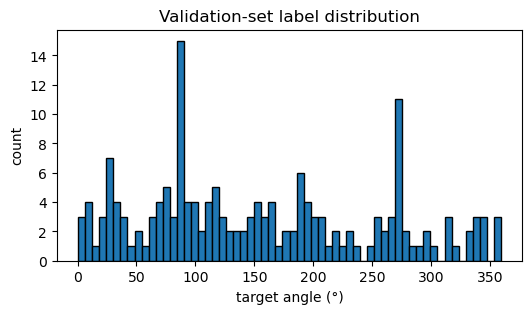

In [ ]:
import matplotlib.pyplot as plt
import torch

# collect every target angle in degrees
y_raw = []
for batch in val_loader:
    y_raw.append(batch.y.cpu())

y_raw = torch.cat(y_raw, 0).numpy()          # shape [N, …]

# (A) if you store sin/cos pairs:
angles = np.rad2deg(np.arctan2(y_raw[:,1], y_raw[:,0])) % 360

# (B) if you already store a scalar angle in radians:
# angles = np.rad2deg(y_raw) % 360

plt.figure(figsize=(6,3))
plt.hist(angles, bins=60, edgecolor="k")
plt.xlabel("target angle (°)")
plt.ylabel("count")
plt.title("Validation-set label distribution")
plt.show()


# Test Zere Edge Ablation

In [ ]:
class ZeroEdgeAttrPair(object):
    def __call__(self, pair):
        pair.edge_attr_s = torch.zeros_like(pair.edge_attr_s)
        pair.edge_attr_t = torch.zeros_like(pair.edge_attr_t)
        return pair
zero_attr     = ZeroEdgeAttrPair() 
mol_dataset.transform = zero_attr


# Split the dataset into train and test sets and val sets [0.8, 0.1, 0.1]
train_0, test_0, val_0 = torch.utils.data.random_split(
    mol_dataset,
    [train_size, test_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(
    train_0,
    batch_size = 64,
    shuffle    = True,
    follow_batch = ['x_s', 'x_t'],    # tells PyG to create x_s_batch, x_t_batch
)
test_loader = DataLoader(
    test_0,
    batch_size = 32,
    shuffle    = False,
    follow_batch = ['x_s', 'x_t'],    # tells PyG to create x_s_batch, x_t_batch
)
val_loader = DataLoader(
    val_0,
    batch_size = 32,
    shuffle    = False,
    follow_batch = ['x_s', 'x_t'],    # tells PyG to create x_s_batch, x_t_batch
)

batch = next(iter(train_loader))
print(batch.edge_attr_s.unique())  # should be tensor([0.])



# Re-initialize the model
model = SiamesePairwise(
    encoder=gnn,
    n_targets=2
)

# Train the model again with the new dataloaders
num_epochs   = 200
best_val_mae = float('inf')
model = model.to(device)
for epoch in range(1, num_epochs + 1):
    # ---------------- TRAIN ----------------
    model.train()
    for pair in train_loader:                 # ← your current loop
        pair   = pair.to(device)
        pred   = model(pair)
        loss   = loss_fn(pred, pair.y.to(device))
        loss.backward()
        optim.step(); optim.zero_grad()

    # ---------------- VALIDATE -------------
    model.eval()
    with torch.no_grad():
        mae, n = 0.0, 0
        for pair in val_loader:
            pair = pair.to(device)
            pred = model(pair)
            mae += torch.abs(pred - pair.y).sum().item()
            n   += pred.size(0)
    val_mae = mae / n

    print(f'Epoch {epoch:3d} | val MAE = {val_mae:7.4f}')

    # ------------- CHECKPOINT --------------
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), 'best.pt')

tensor([0.])


Epoch   1 | val MAE =  1.3913
Epoch   2 | val MAE =  1.3142
Epoch   3 | val MAE =  1.2788
Epoch   4 | val MAE =  1.2869
Epoch   5 | val MAE =  1.2595
Epoch   6 | val MAE =  1.2531
Epoch   7 | val MAE =  1.2733
Epoch   8 | val MAE =  1.2616
Epoch   9 | val MAE =  1.2666
Epoch  10 | val MAE =  1.2689
Epoch  11 | val MAE =  1.2731
Epoch  12 | val MAE =  1.3110
Epoch  13 | val MAE =  1.2660
Epoch  14 | val MAE =  1.2611
Epoch  15 | val MAE =  1.2760
Epoch  16 | val MAE =  1.2707
Epoch  17 | val MAE =  1.2679
Epoch  18 | val MAE =  1.2365
Epoch  19 | val MAE =  1.2602
Epoch  20 | val MAE =  1.2567
Epoch  21 | val MAE =  1.2582
Epoch  22 | val MAE =  1.2462
Epoch  23 | val MAE =  1.2513
Epoch  24 | val MAE =  1.2509
Epoch  25 | val MAE =  1.2301
Epoch  26 | val MAE =  1.2313
Epoch  27 | val MAE =  1.2194
Epoch  28 | val MAE =  1.2393
Epoch  29 | val MAE =  1.2115
Epoch  30 | val MAE =  1.2211
Epoch  31 | val MAE =  1.2201
Epoch  32 | val MAE =  1.2059
Epoch  33 | val MAE =  1.2392
Epoch  34 

In [ ]:
for pair in test_loader:
    print(pair.edge_attr_s)
    break

pair.edge_attr_s.unique()

# Count the number of 1 and 0 in the edge_attr_s
import numpy as np
import torch

# Convert the edge_attr_s to numpy array
edge_attr_s_np = pair.edge_attr_s.cpu().numpy()
# Count the number of 1s and 0s
num_ones = np.sum(edge_attr_s_np == 1)
num_zeros = np.sum(edge_attr_s_np == 0)
print(f'Number of 1s: {num_ones}')
print(f'Number of 0s: {num_zeros}')

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Number of 1s: 0
Number of 0s: 7868


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit import DataStructs
from rdkit.DataStructs import ConvertToNumpyArray

# --- 1. RDKit fingerprint generator (radius=2, 1024 bits) -----------------
GEN = GetMorganGenerator(
        radius            = 2,
        fpSize            = 1024,
        countSimulation   = False,   # <— renamed
        includeChirality  = False,
        useBondTypes      = True)


def smiles_to_fp(smiles: str) -> torch.Tensor:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Could not parse SMILES: {smiles!r}")
    # Generate an ExplicitBitVect
    fp = GEN.GetFingerprint(mol)

    # Get the correct vector length
    nbits = fp.GetNumBits()    # or simply: nbits = len(fp)

    # Allocate a numpy array and copy bits into it
    arr = np.zeros((nbits,), dtype=np.float32)
    ConvertToNumpyArray(fp, arr)

    # Wrap in torch.Tensor
    return torch.from_numpy(arr)

# --- 2. pairwise feature builder ------------------------------------------
def pair_concat(fp_a: torch.Tensor, fp_b: torch.Tensor) -> torch.Tensor:
    """F_concat = [fp_A ‖ fp_B]  → 2048-dim."""
    return torch.cat([fp_a, fp_b], dim=0)

In [ ]:
import os
from pathlib import Path

import pandas as pd
import torch
from torch.utils.data import Dataset
from rdkit import Chem

# your existing utilities:
# from your_fp_module import smiles_to_fp, pair_concat

class PairFingerprintDataset(Dataset):
    def __init__(
        self,
        sdf_path: str,
        input_types: list[str],
        target_csv: str,
        target_columns: list[str] = ['psi_1_dihedral_sin', 'psi_1_dihedral_cos'],
        pair_func = pair_concat,
    ):
        super().__init__()
        self.sdf_path = Path(sdf_path)
        self.input_types = input_types
        self.target_columns = target_columns
        self.pair_func = pair_func

        # Load + normalize the CSV
        df = pd.read_csv(target_csv, dtype={'rxn': str})
        df['rxn'] = df['rxn'].str.strip()
        if 'rxn' not in df.columns:
            raise KeyError("target_csv must contain an 'rxn' column")
        # build a dict: reaction_name -> row Series
        self.target_map = {row.rxn: row for _, row in df.iterrows()}

        # Scan SDFs and collect only those with matching targets
        self.samples: list[tuple[str,str,str]] = []
        for fname in os.listdir(self.sdf_path):
            if not fname.lower().endswith('.sdf'):
                continue
            suppl = Chem.SDMolSupplier(str(self.sdf_path / fname),
                                      removeHs=False, sanitize=False)
            smilesA = smilesB = None
            reaction_name = None

            for mol in suppl:
                if mol is None:
                    continue
                # once per file
                if reaction_name is None:
                    reaction_name = str(mol.GetProp('reaction')).strip()
                t = mol.GetProp('type')
                sm = Chem.MolToSmiles(mol, canonical=True)
                if t == self.input_types[0]:
                    smilesA = sm
                elif t == self.input_types[1]:
                    smilesB = sm

            if reaction_name not in self.target_map:
                print(f"Warning: '{reaction_name}' from {fname} not in target CSV, skipping")
                continue
            if not (smilesA and smilesB):
                print(f"Warning: {fname} missing types {self.input_types}, skipping")
                continue

            self.samples.append((smilesA, smilesB, reaction_name))

        if not self.samples:
            raise RuntimeError("No valid samples found.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx: int):
        smilesA, smilesB, reaction_name = self.samples[idx]
        fp_a = smiles_to_fp(smilesA)
        fp_b = smiles_to_fp(smilesB)
        x = self.pair_func(fp_a, fp_b)

        # fast lookup in our dict
        row = self.target_map[reaction_name]
        y = torch.tensor([row[col] for col in self.target_columns],
                         dtype=torch.float32)
        return x, y


In [ ]:
dataset = PairFingerprintDataset(
    sdf_path = sdf_path,
    input_types = ['r1h', 'r2h'],
    target_csv = target_data,
    target_columns = ['psi_1_dihedral_sin', 'psi_1_dihedral_cos'],
    pair_func = pair_concat
)

In [ ]:
len(dataset)

1696

In [ ]:
# Split the dataset into train and test sets and val sets [0.8, 0.1, 0.1]
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(
    dataset,
    [train_size, test_size, val_size],
    generator=torch.Generator().manual_seed(42)
)
train_loader = DataLoader(
    train_dataset,
    batch_size = 64,
    shuffle    = True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle    = False,
)
val_loader = DataLoader(
    val_dataset,
    batch_size = 32,
    shuffle    = False,
)

In [ ]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512, 2)           # predicts (sin, cos)
).to(device)

loss_fn = cosine_angle_loss    # the function you already wrote
opt     = torch.optim.AdamW(model.parameters(), lr=3e-4)
sched   = CosineRestartsDecay(
            opt,
            T_0     = 20,
            T_mult  = 2,
            eta_min = 1e-4,
            decay   = 0.6)   # ≈ γ

for epoch in range(200):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward(); opt.step(); opt.zero_grad()
    sched.step(epoch=epoch)
    print(f'Epoch {epoch:02d}  train cosine-loss = {loss:.3f}')

    # quick val
    model.eval()
    with torch.no_grad():
        val_loss = torch.mean(torch.stack([
            loss_fn(model(x.to(device)), y.to(device))
            for x, y in val_loader
        ]))
    print(f'Epoch {epoch:02d}  val cosine-loss = {val_loss:.3f}')


Epoch 00  train cosine-loss = 0.665
Epoch 00  val cosine-loss = 0.584
Epoch 01  train cosine-loss = 0.357
Epoch 01  val cosine-loss = 0.569
Epoch 02  train cosine-loss = 0.596
Epoch 02  val cosine-loss = 0.529
Epoch 03  train cosine-loss = 0.631
Epoch 03  val cosine-loss = 0.548
Epoch 04  train cosine-loss = 0.801
Epoch 04  val cosine-loss = 0.523
Epoch 05  train cosine-loss = 0.358
Epoch 05  val cosine-loss = 0.529
Epoch 06  train cosine-loss = 0.233
Epoch 06  val cosine-loss = 0.488
Epoch 07  train cosine-loss = 0.326
Epoch 07  val cosine-loss = 0.515
Epoch 08  train cosine-loss = 0.144
Epoch 08  val cosine-loss = 0.527
Epoch 09  train cosine-loss = 0.399
Epoch 09  val cosine-loss = 0.518
Epoch 10  train cosine-loss = 0.291
Epoch 10  val cosine-loss = 0.559
Epoch 11  train cosine-loss = 0.170
Epoch 11  val cosine-loss = 0.580
Epoch 12  train cosine-loss = 0.077
Epoch 12  val cosine-loss = 0.557
Epoch 13  train cosine-loss = 0.223
Epoch 13  val cosine-loss = 0.526
Epoch 14  train cosi

In [ ]:
for batch in train_loader:
    print(batch)

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[ 3.1904e-01,  9.4774e-01],
        [ 7.6106e-01, -6.4869e-01],
        [-8.3601e-01,  5.4871e-01],
        [ 8.9278e-01, -4.5050e-01],
        [ 1.6196e-01,  9.8680e-01],
        [ 5.7654e-01,  8.1707e-01],
        [-3.4813e-01, -9.3744e-01],
        [-9.6296e-01,  2.6965e-01],
        [-6.4171e-01,  7.6695e-01],
        [-8.3156e-01,  5.5544e-01],
        [ 9.9998e-01,  5.7279e-03],
        [-1.9544e-04,  1.0000e+00],
        [ 9.5617e-01, -2.9281e-01],
        [ 9.9409e-01, -1.0858e-01],
        [ 7.6128e-01,  6.4843e-01],
        [-1.2846e-03,  1.0000e+00],
        [ 9.9942e-01, -3.3919e-02],
        [-8.0866e-01,  5.8828e-01],
        [ 2.8185e-04, -1.0000e+00],
        [ 3.5117e-01,  9.3631e-01],
        [ 3.3967e-01,  9